In [ ]:
import numpy as np
import torch
import random
from transformers import CLIPTextModel, CLIPTokenizer
from utils import search_min_sentence_iteration, genetic, PGDattack, get_char_table, train
device = 'cuda'

len_prompt = 5

tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = text_encoder.to(device)
char_table = get_char_table()

In [ ]:
"""
Backbone of code is taken from: https://github.com/OPTML-Group/QF-Attack
"""

In [2]:
attack_sentence = "a snake and a young man"

#  Greedy
greedy_sentence = search_min_sentence_iteration(attack_sentence, char_table, len_prompt, 
                                                1, tokenizer=tokenizer, text_encoder=text_encoder)
print("greedy_prompt:",greedy_sentence)

#  Genetic
for i in range(1):
    genetic_prompt = genetic(attack_sentence, char_table, len_prompt, tokenizer=tokenizer, 
                             text_encoder=text_encoder)
    genetic_sentence = attack_sentence + ' ' + genetic_prompt[0][0]
    print("genetic_prompt:",genetic_sentence)
    
#  PGD
for i in range(1):
    max_tensor, loss_list, pgd_prompt, max_loss = train(init_per_sample=1, sentence=attack_sentence, 
                                                        len_prompt=len_prompt, char_list=char_table, 
                                                        model=text_encoder.text_model, iter_num = 100, 
                                                        eta_u=1, tokenizer=tokenizer, text_encoder=text_encoder)  
    pgd_sentence = attack_sentence + ' ' + pgd_prompt
    print("pgd_prompt:",pgd_sentence)

greedy_prompt: a snake and a young man U6APX
genetic_prompt: a snake and a young man M\,BR
pgd_prompt: a snake and a young man 67#^@


In [ ]:
from diffusers import StableDiffusionPipeline
from torch import autocast
from utils import image_grid
# pipe = StableDiffusionPipeline.from_pretrained('CompVis/stable-diffusion-v1-4',torch_dtype=torch.float16)
pipe = StableDiffusionPipeline.from_pretrained(
    'CompVis/stable-diffusion-v1-4', revision='fp16',
    torch_dtype=torch.float16)
pipe = pipe.to(device)

100%|██████████| 50/50 [02:01<00:00,  2.44s/it]


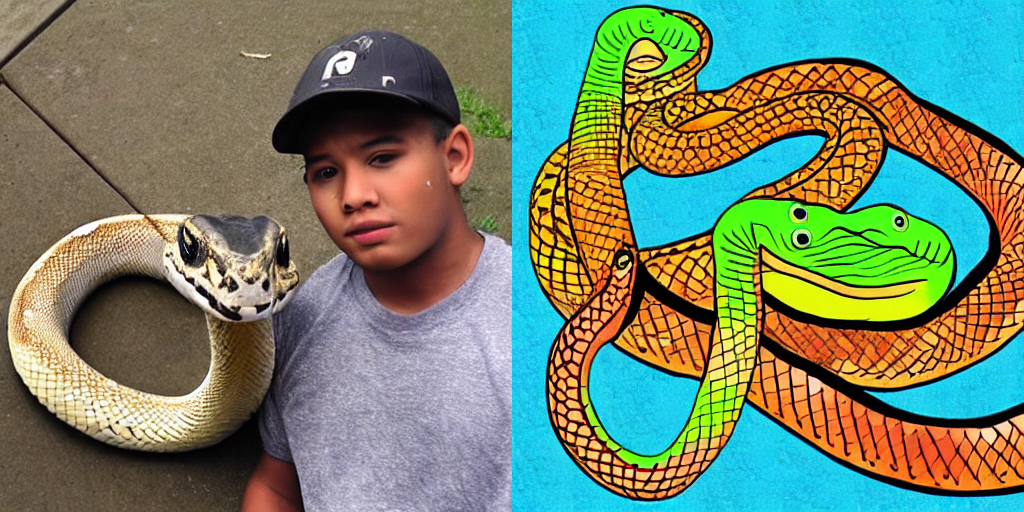

In [24]:
generator = torch.Generator("cuda").manual_seed(27)

original_sentence = 'a snake and a young man'
perturbation_prompt = 'M\,BR'
sentence = original_sentence + ' ' + perturbation_prompt

num_images = 2
#prompt = [sentence] * num_images
prompt = [original_sentence, sentence]
images = pipe(prompt, generator=generator, num_inference_steps=50).images

grid = image_grid(images, rows=1, cols=2)
grid

In [7]:
from transformers import CLIPProcessor, CLIPModel
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
def compute_clip_score(prompt, image, model=clip_model, processor=clip_processor, device=device):
    inputs = processor(text=prompt, images=image, return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)
    text_embeds = outputs.text_embeds
    image_embeds = outputs.image_embeds
    text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
    image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
    similarity = (text_embeds * image_embeds).sum(dim=-1)
    return similarity.item()

100%|██████████| 50/50 [00:34<00:00,  1.43it/s]


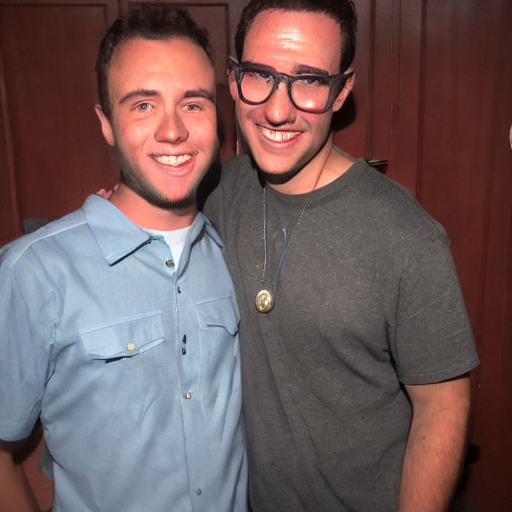

In [8]:
prompt = "two dudes"
with autocast('cuda'):
    image = pipe(prompt, generator=generator, num_inference_steps=50).images

grid = image_grid(image, rows=1, cols=1)
grid

In [14]:
prompt_list = [
    "A black panther lying in a jungle and a young man",
    "A fishing boat on a lake at sunrise and a young man",
    "A tea cup on a saucer with a teapot and a young man",
    "A man playing guitar on a street corner and a young man",
    "A group of flamingos standing in a pond and a young man",
    "A fireflies in a field at dusk and a young man",
    "A train chugging through a countryside and a young man",
    "A butterfly on a colorful flower and a young man",
    "A soccer game being played on a stadium and a young man",
    "A man kayaking down a river through rapids and a young man",
    "A monk meditating in a temple",
    "A dolphin jumping through ocean waves",
    "A farmer harvesting wheat in a field",
    "A street performer juggling in a plaza",
    "A climber scaling a rocky cliff",
    "A potter shaping clay on a wheel",
    "A ballerina practicing in a studio",
    "A photographer capturing desert landscapes",
    "A gondolier rowing through Venice canals",
    "A beekeeper tending to honeycomb hives"
]

In [15]:
prompt_dict = {}
for prompt in prompt_list:

    random_prompt = ''.join(random.sample(char_table, 5))

    random_sentence = prompt + ' ' + random_prompt

    print("random_sentence:",random_sentence)

    greedy_sentence = search_min_sentence_iteration(prompt, char_table, len_prompt, 
                                                1, tokenizer=tokenizer, text_encoder=text_encoder)
    
    print("greedy_sentence:",greedy_sentence)
    
    genetic_prompt = genetic(prompt, char_table, len_prompt, tokenizer=tokenizer, 
                             text_encoder=text_encoder)
    genetic_sentence = prompt + ' ' + genetic_prompt[0][0]
    
    print("genetic_sentence:",genetic_sentence)

    max_tensor, loss_list, pgd_prompt, max_loss = train(init_per_sample=1, sentence=prompt, 
                                                        len_prompt=len_prompt, char_list=char_table, 
                                                        model=text_encoder.text_model, iter_num = 100, 
                                                        eta_u=1, tokenizer=tokenizer, text_encoder=text_encoder)  
    pgd_sentence = prompt + ' ' + pgd_prompt
    
    
    
    print("pgd_sentence:",pgd_sentence)
    prompt_dict[prompt] = {
        'random':random_sentence, 
        'greedy': greedy_sentence, 
        'genetic': genetic_sentence, 
        'pgd': pgd_sentence
    }

random_sentence: A black panther lying in a jungle and a young man #4*TY
greedy_sentence: A black panther lying in a jungle and a young man W)6%|
genetic_sentence: A black panther lying in a jungle and a young man =M6<X
pgd_sentence: A black panther lying in a jungle and a young man Q?\<X
random_sentence: A fishing boat on a lake at sunrise and a young man 5|@X6
greedy_sentence: A fishing boat on a lake at sunrise and a young man D$R<X
genetic_sentence: A fishing boat on a lake at sunrise and a young man U#T!V
pgd_sentence: A fishing boat on a lake at sunrise and a young man 4%7?C
random_sentence: A tea cup on a saucer with a teapot and a young man '7C;<
greedy_sentence: A tea cup on a saucer with a teapot and a young man V8<X·
genetic_sentence: A tea cup on a saucer with a teapot and a young man GX|ID
pgd_sentence: A tea cup on a saucer with a teapot and a young man 8536*
random_sentence: A man playing guitar on a street corner and a young man K#C0*
greedy_sentence: A man playing guit

In [16]:
from collections import defaultdict
clip_scores_dict = defaultdict(list)
for key, value in prompt_dict.items():
    for i in range(10):
        original_image = pipe(key, generator=generator, num_inference_steps=50).images
        original_score = compute_clip_score(key, original_image)
        clip_scores_dict['original'].append(original_score)

        greedy_image = pipe(value['greedy'], generator=generator, num_inference_steps=50).images
        greedy_score = compute_clip_score(value['greedy'], greedy_image)
        clip_scores_dict['greedy'].append(greedy_score)

        random_image = pipe(value['random'], generator=generator, num_inference_steps=50).images
        random_score = compute_clip_score(value['random'], random_image)
        clip_scores_dict['random'].append(random_score)

        genetic_image = pipe(value['genetic'], generator=generator, num_inference_steps=50).images
        genetic_score = compute_clip_score(value['genetic'], genetic_image)
        clip_scores_dict['genetic'].append(genetic_score)

        pgd_image = pipe(value['pgd'], generator=generator, num_inference_steps=50).images
        pgd_score = compute_clip_score(value['pgd'], pgd_image)
        clip_scores_dict['pgd'].append(pgd_score)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:12<00:00,  4.12it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 50/50 [00:12<00:00,  4.12it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


In [17]:
stats_dict = {}
    
for method, scores in clip_scores_dict.items():
    scores_array = np.array(scores)
    stats_dict[method] = {
        'mean': float(np.mean(scores_array)),
        'std': float(np.std(scores_array)),
    }
print(stats_dict)

{'original': {'mean': 0.2618869292239348, 'std': 0.02141078409981715}, 'greedy': {'mean': 0.24723880191644032, 'std': 0.028227769666063555}, 'random': {'mean': 0.2612808557848136, 'std': 0.029851334073611516}, 'genetic': {'mean': 0.24474516461292903, 'std': 0.04046669316847152}, 'pgd': {'mean': 0.23756706739465397, 'std': 0.041321075893054005}}


In [13]:
stats_dict = {}
    
for method, scores in clip_scores_dict.items():
    scores_array = np.array(scores)
    stats_dict[method] = {
        'mean': float(np.mean(scores_array)),
        'std': float(np.std(scores_array)),
    }
print(stats_dict)

{'original': {'mean': 0.2644871530433496, 'std': 0.022443257540868018}, 'greedy': {'mean': 0.25024926538268727, 'std': 0.03271718559139328}, 'random': {'mean': 0.25685913984974224, 'std': 0.026506431997265805}, 'genetic': {'mean': 0.25084993441899617, 'std': 0.03280289167514654}, 'pgd': {'mean': 0.2482397879163424, 'std': 0.04096581900136129}}
